In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterGrid

### Data-Set: https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python/data

In [2]:
file = open('/Users/tibet/Python Workspaces/KlimaCluster/Datensatz/Mall_Customers.csv', "r")
data = list(csv.reader(file, delimiter=","))
file.close()
df = pd.DataFrame(data[1::], columns = data[0])

In [3]:
df.head(20)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [4]:
df.describe()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200,200,200,200,200
unique,200,2,51,64,84
top,1,Female,32,54,42
freq,1,112,11,12,8


In [5]:
df.dtypes

CustomerID                object
Gender                    object
Age                       object
Annual Income (k$)        object
Spending Score (1-100)    object
dtype: object

## Zahlen-Werte haben den Datentyp object und müssen daher in int konvertiert werden, um Statistikwerte bei .describe berechnen zu können

In [6]:
df['CustomerID'] = pd.to_numeric(df['CustomerID'])
df['Age'] = pd.to_numeric(df['Age'])
df['Annual Income (k$)'] = pd.to_numeric(df['Annual Income (k$)'])
df['Spending Score (1-100)'] = pd.to_numeric(df['Spending Score (1-100)'])

In [7]:
df.dtypes

CustomerID                 int64
Gender                    object
Age                        int64
Annual Income (k$)         int64
Spending Score (1-100)     int64
dtype: object

In [8]:
pd.set_option('display.float_format', '{:.3f}'.format)
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000,200.000,200.000,200.000
mean,100.500,38.850,60.560,50.200
std,57.879,13.969,26.265,25.824
min,1.000,18.000,15.000,1.000
25%,50.750,28.750,41.500,34.750
50%,100.500,36.000,61.500,50.000
75%,150.250,49.000,78.000,73.000
max,200.000,70.000,137.000,99.000


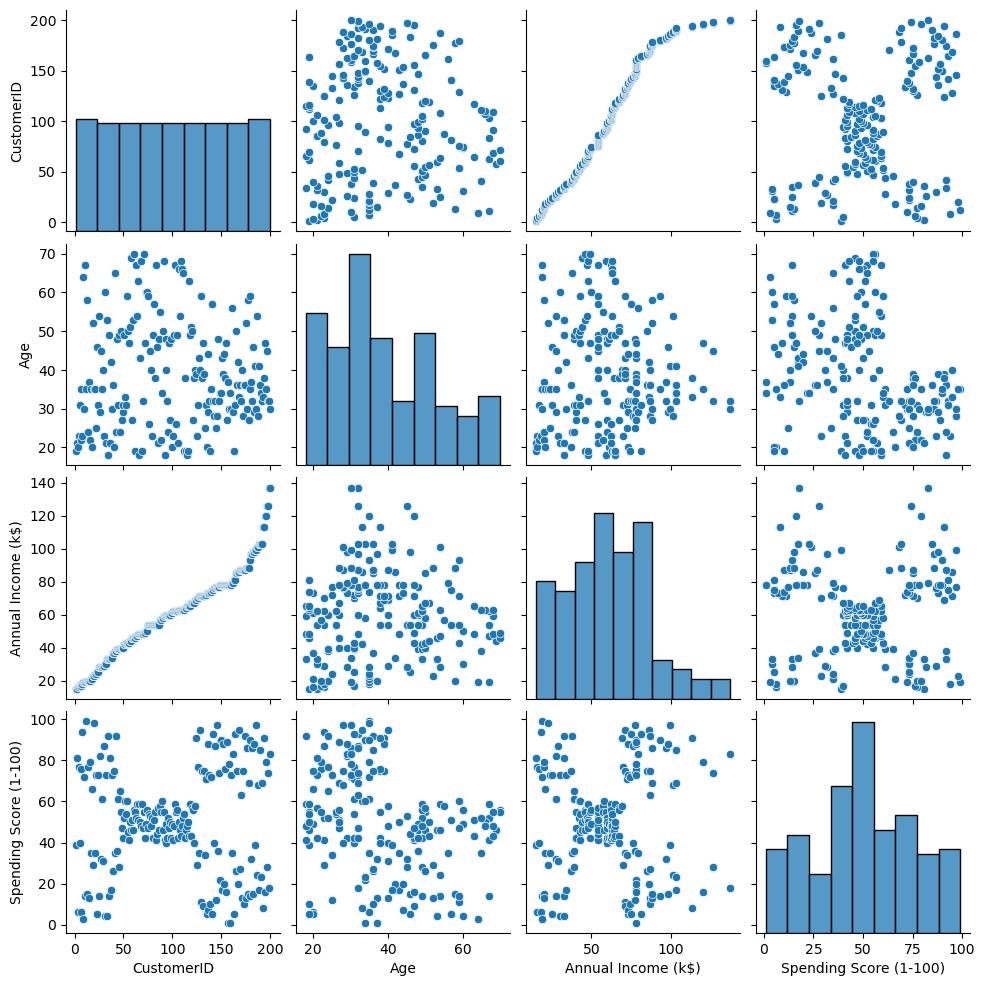

In [9]:
sns.pairplot(df)

## CustomerID bietet keinen Mehrwert für den Datensatz und wird daher entfernt

In [10]:
df = df.drop(columns='CustomerID')

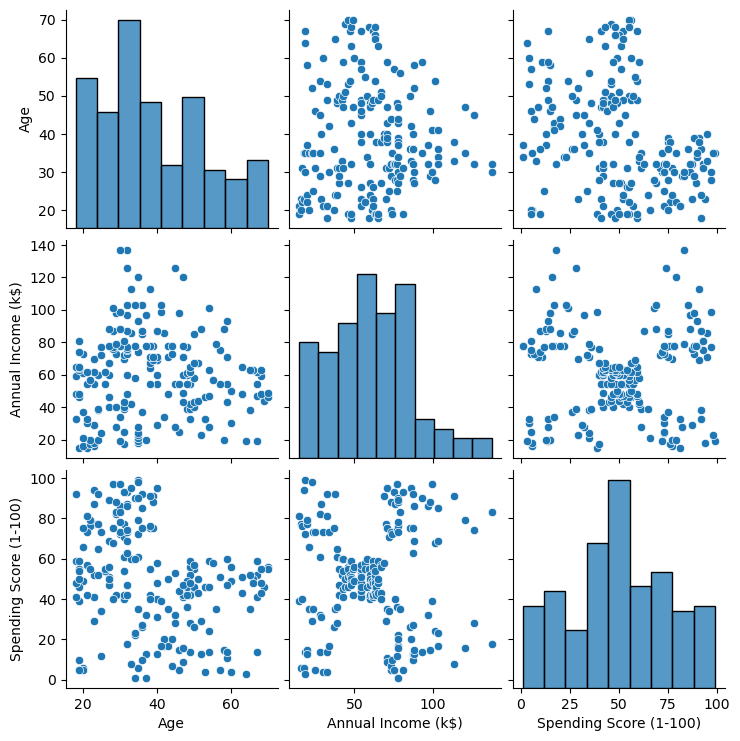

In [11]:
sns.pairplot(df)

<AxesSubplot:>

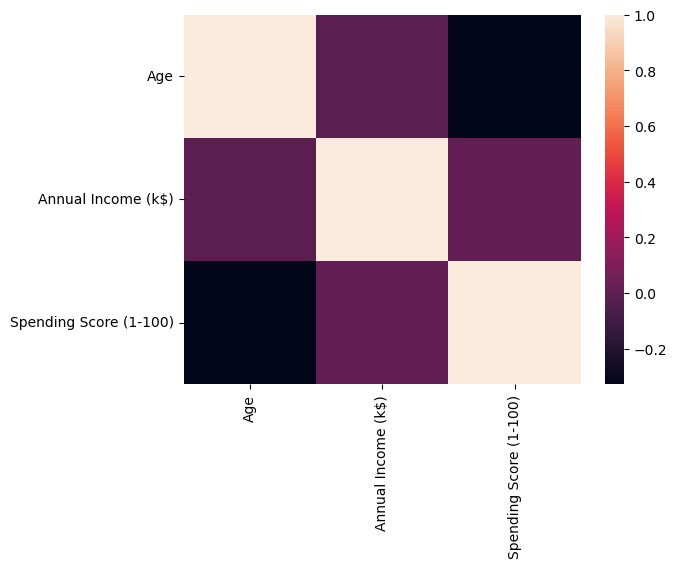

In [12]:
sns.heatmap(df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].corr())

In [13]:
cluster_df = df[['Annual Income (k$)', 'Spending Score (1-100)']].copy()
cluster_df.head()

,Annual Income (k$),Spending Score (1-100)
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


## Modell Erstellung

In [14]:
best_score = -1  # Initialisieren des Silhouettenwert mit -1
best_params = {}  # Initialisieren der Hyperparameter

param_grid = {
    'eps': [1, 1.5, 2, 2.5, 3, 3.5, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    'min_samples': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'metric': ['euclidean', 'manhattan']
}

silhouette_score_list = []
num_clusters = []

# Durchlaufen aller Hyperparameter-Kombinationen
for params in ParameterGrid(param_grid):
    db = DBSCAN(**params)
    labels = db.fit_predict(cluster_df)
    if len(set(labels)) > 1:  #Überprüfen ob mehr als ein Cluster erstellt worden ist, da für den Silhouette-Score mehr als ein Cluster benötigt werden
        score = silhouette_score(cluster_df, labels)
        num_clusters.append(len(set(labels)))

        if score > best_score:
            best_score = score
            best_params = params
        silhouette_score_list.append(score)

print("Beste Parameter: ", best_params)
print("Bester Silhouette-Score: ", best_score)
print('Optimale Anzahl der Cluster', num_clusters[silhouette_score_list.index(best_score)])

Beste Parameter:  {'eps': 9, 'metric': 'euclidean', 'min_samples': 3}
Bester Silhouette-Score:  0.475053701963407
Optimale Anzahl der Cluster 8


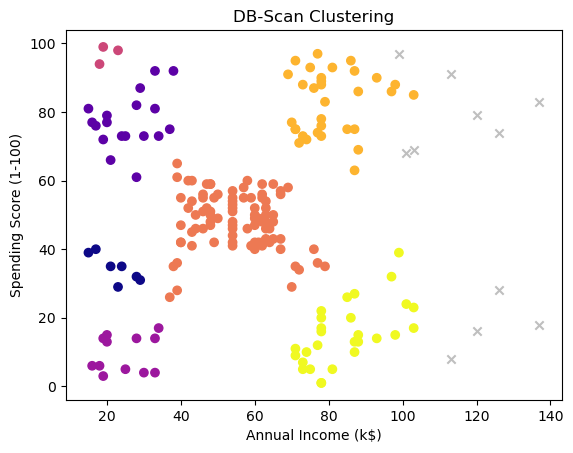

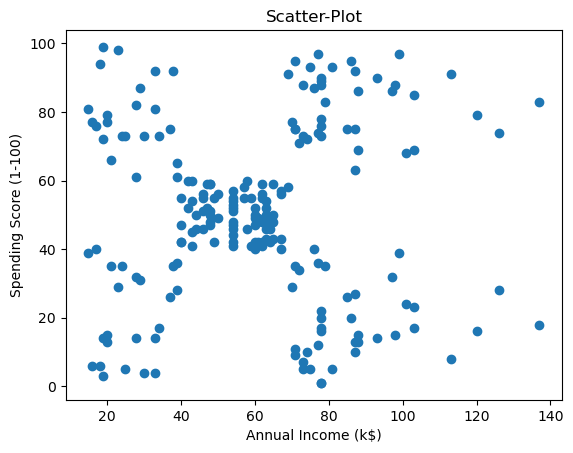

In [15]:
db=DBSCAN(eps=best_params['eps'],min_samples=best_params['min_samples'],metric='euclidean')
# db=DBSCAN(eps=10,min_samples=best_params['min_samples'],metric='euclidean')

#db=DBSCAN(eps=7,min_samples=3,metric='euclidean')

y_means = db.fit_predict(cluster_df)
# plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"], c=y_means, cmap='plasma')
# Scatter-Plot für Noise (-1)
noise_indices = np.where(y_means == -1)
plt.scatter(cluster_df.iloc[noise_indices]["Annual Income (k$)"], cluster_df.iloc[noise_indices]["Spending Score (1-100)"], c='gray', marker='x', label='Noise', alpha=0.5)

# Scatter-Plot für Cluster
cluster_indices = np.where(y_means != -1)
plt.scatter(cluster_df.iloc[cluster_indices]["Annual Income (k$)"], cluster_df.iloc[cluster_indices]["Spending Score (1-100)"], c=y_means[cluster_indices], cmap='plasma', label='Clusters')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('DB-Scan Clustering')
plt.show()

plt.scatter(cluster_df["Annual Income (k$)"], cluster_df["Spending Score (1-100)"])
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('Scatter-Plot')
plt.show()

## Ermittlung der Hyperparameter anhand eines K-distance Graphs

In [16]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=20)
nbrs = neigh.fit(cluster_df)
distances, indices = nbrs.kneighbors(cluster_df)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

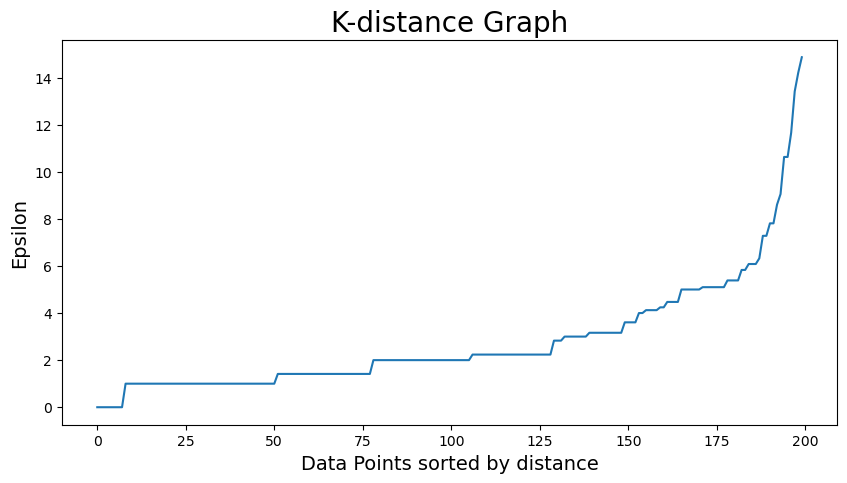

In [17]:
plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title('K-distance Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

## Vergleich der beiden Clusterings

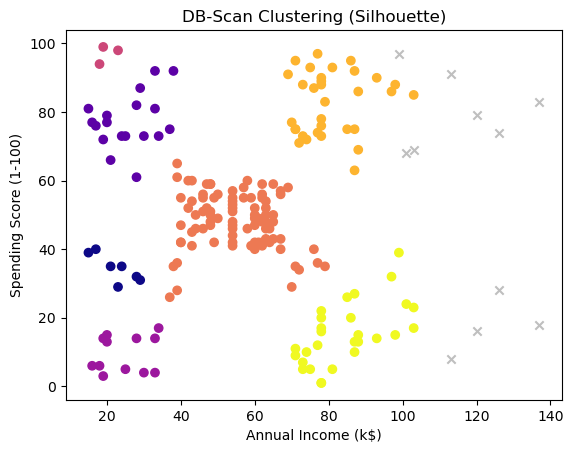

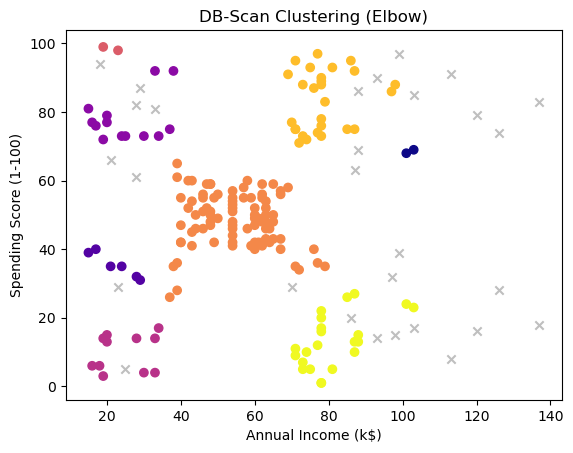

In [18]:
db=DBSCAN(eps=best_params['eps'],min_samples=best_params['min_samples'],metric='euclidean')

y_means = db.fit_predict(cluster_df)
# plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"], c=y_means, cmap='plasma')
noise_indices = np.where(y_means == -1)
plt.scatter(cluster_df.iloc[noise_indices]["Annual Income (k$)"], cluster_df.iloc[noise_indices]["Spending Score (1-100)"], c='gray', marker='x', label='Noise', alpha=0.5)

# Scatter-Plot für Cluster
cluster_indices = np.where(y_means != -1)
plt.scatter(cluster_df.iloc[cluster_indices]["Annual Income (k$)"], cluster_df.iloc[cluster_indices]["Spending Score (1-100)"], c=y_means[cluster_indices], cmap='plasma', label='Clusters')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('DB-Scan Clustering (Silhouette)')
plt.show()

db2=DBSCAN(eps=5,min_samples=2,metric='euclidean')
y_means2 = db2.fit_predict(cluster_df)
# plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"], c=y_means2, cmap='cool')
noise_indices = np.where(y_means2 == -1)
plt.scatter(cluster_df.iloc[noise_indices]["Annual Income (k$)"], cluster_df.iloc[noise_indices]["Spending Score (1-100)"], c='gray', marker='x', label='Noise', alpha=0.5)

# Scatter-Plot für Cluster
cluster_indices = np.where(y_means2 != -1)
plt.scatter(cluster_df.iloc[cluster_indices]["Annual Income (k$)"], cluster_df.iloc[cluster_indices]["Spending Score (1-100)"], c=y_means[cluster_indices], cmap='plasma', label='Clusters')

plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.title('DB-Scan Clustering (Elbow)')
plt.show()


In [19]:
y_means

array([ 0,  1,  2,  1,  0,  1,  2,  3,  2,  1,  2,  3,  2,  1,  2,  1,  0,
        1,  0,  3,  0,  1,  2,  1,  2,  1,  0,  1,  0,  1,  2,  1,  2,  1,
        2,  1,  2,  1,  4,  1,  4,  1,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  4,  5,  4,  5,  6,  5,  6,  5,  4,  5,  6,  5,
        6,  5,  6,  5,  6,  5,  4,  5,  6,  5,  4,  5,  6,  5,  6,  5,  6,
        5,  6,  5,  6,  5,  6,  5,  4,  5,  6,  5,  6,  5,  6,  5,  6,  5,
        6,  5,  6,  5,  6,  5,  6,  5,  6,  5,  6,  5,  6,  5,  6, -1,  6,
       -1,  6,  5,  6, -1, -1, -1, -1, -1, -1, -1, -1, -1])